## Default of credit card clients

#### Given the data about the credit card defaults in 2005, Taiwan, predict the if a client will default on her credit card payment in the next period

#### Tags:
    Data: labeled data, Kaggle competition
    Technologies: python, pandas, sklearn
    Techniques: end-to-end project
    
#### Resources:

[UCI Machine Learning Repository - Default of Credit Clients](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#)

[ROC curve and AUC](https://www.youtube.com/watch?v=OAl6eAyP-yo)

[Xtreme Gradient Boosting](https://github.com/dmlc/xgboost)

#### Papers

Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.

### The question asked

We need to answer the questions:
- Can we predict which clients will default in the next period? 
- If so, how accurate can we get?
- Can we also predict what is the clients probability of defaulting in the next period?
- Are there any ideas on how to improve the accuracy?
    
### The data provided

The data consists of payment data for October 2005, from an important bank in Taiwan and the targets were the credit card holders of the bank. There are 30000 observations with the 22.12% clients with the default payment. 

The data is connected to the reasearch paper mentioned in the Papers above.

The data consists of a single dataset 

    1. default-of-credit-card-clients.xls
    
Data description:

1. X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
2. X2: Gender (1 = male; 2 = female).
3. X3: Education (1 = graduate school; 2 = university;3 = high school; 4 = others)
4. X4: Marital status (1 = married; 2 = single; 3 = others).
5. X5: Age (year).
6. X6–X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August,2005; . . .; X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: 1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
7. X12–X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.10. X18–X23: Amount of previous payment (NT dollar).X18 = amount paid in September, 2005; X19 = amountpaid in August, 2005; . . .; X23 = amount paid in April, 2005
    
Data fields:

    1. ID - id of the column
    2. LIMIT_BAL
    3. SEX
    4. EDUCATION
    5. MARRIAGE
    6. AGE
    7. PAY_0
    8. PAY_1
    9. PAY_2
    10. PAY_3
    11. PAY_4
    12. PAY_5
    13. PAY_6
    14. BILL_AMT1
    15. BILL_AMT2
    16. BILL_AMT3
    17. BILL_AMT4
    18. BILL_AMT5
    19. BILL_AMT6
    20. PAY_AMT1
    21. PAY_AMT2
    22. PAY_AMT3
    23. PAY_AMT4
    24. PAY_AMT5
    25. PAY_AMT6
    26. default payment next month
            
### Approach chosen

After some exploratory data analysis i will use the sklearn classification models to find the one that has the highest AUC score. In the process i will optimize the hyper-parameters for each of the models and later compare them.

Not all of the attempts to understand the data and choose the best solution will be shown here.


In [43]:
# import the needed libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import pickle
%matplotlib inline

from scipy.stats import gamma
from scipy.stats import randint as sp_randint

from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb


In [4]:
# Helpful functions

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plts the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#     plt.tight_layout()
    plt.show()


def df_stats(df):
    '''
    Given pandas dataset provides basic information
    '''
    
    print("----------Top-5- Record----------")
    print(df.head(5))
    print("-----------Information-----------")
    print(df.info())
    print("-----------Data Types-----------")
    print(df.dtypes)
    print("----------Missing value-----------")
    print(df.isnull().sum())
    print("----------Null value-----------")
    print(df.isna().sum())
    print("----------Shape of Data----------")
    print(df.shape)
    print("----------Potential Duplicates----------")
    print(df.duplicated().sum())
        
def plot_roc_curve(fpr, tpr, label=None):
       
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.show()


def show_feature_importances(predictors, fitted_model):
    
    tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': fitted_model.feature_importances_})
    tmp = tmp.sort_values(by='Feature importance',ascending=False)
    plt.figure(figsize = (7,4))
    plt.title('Feature importances',fontsize=14)
    s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show()   

def plotLearningCurve(_x_train, _y_train, learning_model_pipeline,  k_fold = 10, training_sample_sizes = np.linspace(0.1,1.0,10), jobsInParallel = -1):
    
    training_size, training_score, testing_score = learning_curve(estimator = learning_model_pipeline, \
                                                                X = _x_train, \
                                                                y = _y_train, \
                                                                train_sizes = training_sample_sizes, \
                                                                cv = k_fold, \
                                                                scoring = 'roc_auc', \
                                                                n_jobs = jobsInParallel) 


    training_mean = np.mean(training_score, axis = 1)
    training_std_deviation = np.std(training_score, axis = 1)
    testing_std_deviation = np.std(testing_score, axis = 1)
    testing_mean = np.mean(testing_score, axis = 1 )

    ## we have got the estimator in this case the perceptron running in 10 fold validation with 
    ## equal division of sizes betwwen .1 and 1. After execution, we get the number of training sizes used, 
    ## the training scores for those sizes and the test scores for those sizes. we will plot a scatter plot 
    ## to see the accuracy results and check for bias vs variance

    # training_size : essentially 10 sets of say a1, a2, a3,,...a10 sizes (this comes from train_size parameter, here we have given linespace for equal distribution betwwen 0.1 and 1 for 10 such values)
    # training_score : training score for the a1 samples, a2 samples...a10 samples, each samples run 10 times since cv value is 10
    # testing_score : testing score for the a1 samples, a2 samples...a10 samples, each samples run 10 times since cv value is 10
    ## the mean and std deviation for each are calculated simply to show ranges in the graph

    plt.plot(training_size, training_mean, label= "Training Data", marker= '+', color = 'blue', markersize = 8)
    plt.fill_between(training_size, training_mean+ training_std_deviation, training_mean-training_std_deviation, color='blue', alpha =0.12 )

    plt.plot(training_size, testing_mean, label= "Testing/Validation Data", marker= '*', color = 'green', markersize = 8)
    plt.fill_between(training_size, testing_mean+ testing_std_deviation, testing_mean-testing_std_deviation, color='green', alpha =0.14 )

    plt.title("Scoring of our training and testing data vs sample sizes")
    plt.xlabel("Number of Samples")
    plt.ylabel("Score")
    plt.legend(loc= 'best')
    plt.show()
        

In [5]:
# Load the dataset from excel file

df = pd.read_excel('data/default-of-credit-card-clients.xls', skiprows=1)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID                            30000 non-null int64
LIMIT_BAL                     30000 non-null int64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_0                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null int64
BILL_AMT2                     30000 non-null int64
BILL_AMT3                     30000 non-null int64
BILL_AMT4                     30000 non-null int64
BILL_AMT5                     30000 non-null int64
BILL_AMT6               

In [6]:
df_stats(df)

----------Top-5- Record----------
   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...          0          0          0         0       689         0   
1  ...       3272       3455       3261         0      1000      1000   
2  ...      14331      14948      15549      1518      1500      1000   
3  ...      28314      28959      29547      2000      2019      1200   
4  ...      20940      19146      19131      2000     36681     10000   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default payment nex

Exploratory data analysis
-----------------------------

From above we can confirm that all of the features are treated as numeric. The column ID is keeps just the row numbers, and as we are not sure how the data was sequenced, will not be relevant in building the model. 

In [7]:
# Removing the ID feature from the data

df = df.drop('ID', axis=1)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
LIMIT_BAL                     30000 non-null int64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_0                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null int64
BILL_AMT2                     30000 non-null int64
BILL_AMT3                     30000 non-null int64
BILL_AMT4                     30000 non-null int64
BILL_AMT5                     30000 non-null int64
BILL_AMT6                     30000 non-null int64
PAY_AMT1                

Data Cleaning
---------------

There are values 0,5 and 6 in feature EDUCATION that are not explained by the supporting documentation. Iv decided to group them in the option 4 - Other. 

There is value 0 in feature MARRIAGE that is not explained by the supporting documentation and this value will be added to option 3 - Other.

Further investigation could be done to check if this makes sense, or more information might be requested from the ower of the data.


In [8]:
print(df.EDUCATION.value_counts(sort=False))

df.loc[(df.EDUCATION == 0) | (df.EDUCATION == 5) | (df.EDUCATION == 6),'EDUCATION'] = 4

print(df.EDUCATION.value_counts(sort=False))


print(df.MARRIAGE.value_counts(sort=False))

df.loc[(df.MARRIAGE == 0),'MARRIAGE'] = 3

print(df.MARRIAGE.value_counts(sort=False))



0       14
1    10585
2    14030
3     4917
4      123
5      280
6       51
Name: EDUCATION, dtype: int64
1    10585
2    14030
3     4917
4      468
Name: EDUCATION, dtype: int64
0       54
1    13659
2    15964
3      323
Name: MARRIAGE, dtype: int64
1    13659
2    15964
3      377
Name: MARRIAGE, dtype: int64


Additional Data Inspection
---------------------------

Althought the dataset looks clean there are some questions about it. For 
instance there are 795 rows that Bill amt. and Pay amt. =0. Also in the PAY_0
there are many entries with value of 1 and -2 (i assumed this value means "null"). 

To me this suggests that here is also included the data for the clients that 
just started with their credit obligations. For these there is very little 
historical transactional data, hence making predictions would be based on just
client master data which is probably unsufficient to create a good model.

Hence i would exclude these entries during the model selection process to 
try to improve the model perfromance.

Example are IDs: 19, 20, 46, 80


Categorical variables
----------------------

There are several categorical variables and we will create dummy variables for
them so that they can be successfully used with the models that we will attempt.


In [9]:
df4model = pd.get_dummies(df,columns=['SEX','EDUCATION','MARRIAGE'])
df4model.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 30 columns):
LIMIT_BAL                     30000 non-null int64
AGE                           30000 non-null int64
PAY_0                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null int64
BILL_AMT2                     30000 non-null int64
BILL_AMT3                     30000 non-null int64
BILL_AMT4                     30000 non-null int64
BILL_AMT5                     30000 non-null int64
BILL_AMT6                     30000 non-null int64
PAY_AMT1                      30000 non-null int64
PAY_AMT2                      30000 non-null int64
PAY_AMT3                      30000 non-null int64
PAY_AMT4                

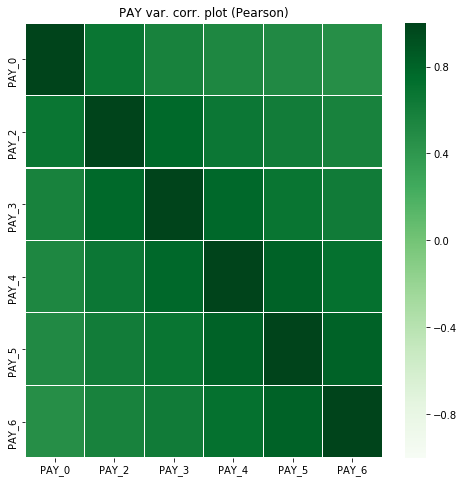

In [10]:
var = ['PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

plt.figure(figsize = (8,8))
plt.title('PAY var. corr. plot (Pearson)')
corr = df[var].corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,vmin=-1, vmax=1, cmap="Greens")
plt.show()

## High correlations between payment tracking variables

There seems to be high correlation between PAY, BILL_AMT and PAY_AMT variables
as well as between the different months. This reduces the model quality, hence
either a high L2 regularization is needed or we can just remove the features that are 
highly correlated. Another way of looking at it that there is little additional information 
in the key features. If the categorical variables (EDUCATION, SEX, etc.) can
not bring some additional information about predicting the default then it is 
difficult to see how a good model can be built.


In [11]:
def boxplot_variation(feature1, feature2, feature3=0, width=16):
    fig, ax1 = plt.subplots(ncols=1, figsize=(width,6))
    
    if feature3==0:
        s = sns.boxplot(ax = ax1, x=feature1, y=feature2, data=df, palette="Blues",showfliers=False)
    else:
        s = sns.boxplot(ax = ax1, x=feature1, y=feature2, hue=feature3,
                    data=df, palette="Blues",showfliers=False)        
        
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show();


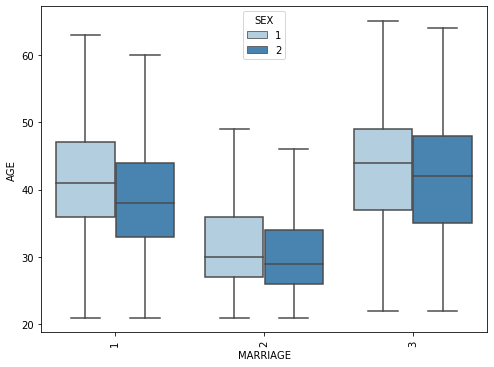

In [12]:
boxplot_variation('MARRIAGE','AGE', 'SEX',8)

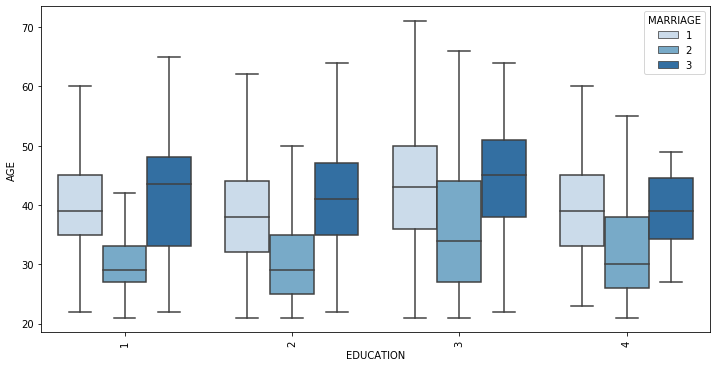

In [13]:
boxplot_variation('EDUCATION','AGE','MARRIAGE',width=12)

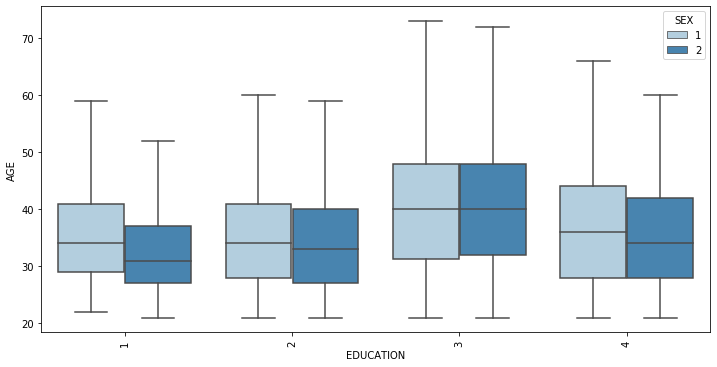

In [14]:
boxplot_variation('EDUCATION','AGE','SEX',width=12)

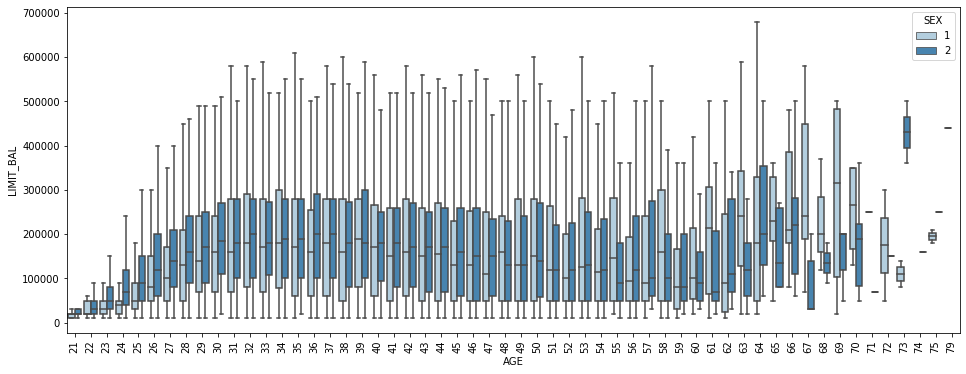

In [88]:
boxplot_variation('AGE','LIMIT_BAL', 'SEX',16)

## Categorical variables - relationships between explanatory features

With categorical variable Marriage there is also a value 0 which is not clearly explained in the data description. 

Other than that there seems nothing particulary unexpected in the distribution of variables. The more credit card limit is available as the clients get towards 30 years old and from there onwards it is more or less stable until above 60 yr old where it increses slightly. Above 66 yr old there is not enough data to make conslusions (divergence at the end). 

Notice that here there might be other interpretations of these overviews depending on the domain knowledge understanding so these charts should be discussed with domain experts in order to confirm that the assumptions make sense.

Next we will take a look at the frequencies of clients who defaulted and effect of the categorical variables on the outcome. This can help understand the relationships better and maybe develop some farther assumptions.



In [107]:
# Distribution of clients tha defaulted

print('Proportions of clients that defaulted or not')
print(df['default payment next month'].value_counts())

print('\nPercentage of clients that defaulted: {}'.format((df['default payment next month'].value_counts()[1]) / len(df)))

def target_freq(Col1, Col2):
    res = df.groupby([Col1, Col2]).size().unstack()    
    res['perc'] = (res[res.columns[1]]/(res[res.columns[0]] + res[res.columns[1]]))
    res['perc'] = round(res['perc'],2)
    return res


print(target_freq('EDUCATION', 'default payment next month'))
print('\n')
print(target_freq('MARRIAGE', 'default payment next month'))
print('\n')
print(target_freq('SEX', 'default payment next month'))
print('\n')
print(target_freq('AGE', 'default payment next month'))


Proportions of clients that defaulted or not
0    23364
1     6636
Name: default payment next month, dtype: int64

Percentage of clients that defaulted: 0.2212
default payment next month      0     1  perc
EDUCATION                                    
1                            8549  2036  0.19
2                           10700  3330  0.24
3                            3680  1237  0.25
4                             435    33  0.07


default payment next month      0     1  perc
MARRIAGE                                     
1                           10453  3206  0.23
2                           12623  3341  0.21
3                             288    89  0.24


default payment next month      0     1  perc
SEX                                          
1                            9015  2873  0.24
2                           14349  3763  0.21


default payment next month       0      1  perc
AGE                                            
21                            53.0   14.0  0.21


## Categorical variables - relationships between explanatory and dependant feature

Looking at just the frequencies of the dependant feature we see that out of 30K clients 6636 have defaulted in the last month making the total average default proportion of 22.12%.

Education - the least educated clients have the default proportion of 19% which is slightly less than total average and the most educated clients have default proportion of 7% which is more then 3 times less than average. 

Marriage - married and other clients have a couple percentage points higher proportion of defeault than average.

Sex - males have a slightly higher default percentage than average, while females have a slightly lower default percentage than average.

Age - it looks like the middle-aged people have more or less the default proportion as the total, while the younger (till 24) and the older (above 55) are more likely to default.

Again these observations are considering only the 2 variables, hence any covariance effect is not accounted for (e.g. like in multivariate regression).

Modelling
-------




In [15]:
# create the training and test sets

X = df4model.drop('default payment next month',axis=1)
y = df4model['default payment next month']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Logistic Regression
--------

In [117]:
############################################
## 1 ## Multivariate logistic regression  ##
############################################

## Attempting a randomized search to find a better model


model = LogisticRegression(random_state=42, 
                           class_weight='balanced', 
                           max_iter=150,
                           n_jobs=-1)

steps = [('scaler', StandardScaler()), ('LR', model)]
pipeline = Pipeline(steps) 


params = {'LR__C':gamma.rvs(2, size=10000),
          'LR__solver':['newton-cg', 'liblinear', 'saga']}

random_search = RandomizedSearchCV(pipeline, 
                                   param_distributions=params, 
                                   cv=3, 
                                   n_iter=21,
                                   scoring='roc_auc',
                                   iid=False, 
                                   verbose=100)

random_search.fit(X_train, y_train)

print(random_search.best_estimator_)
print(random_search.best_score_)



Fitting 3 folds for each of 21 candidates, totalling 63 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] LR__solver=saga, LR__C=2.7805636196725927 .......................
[CV]  LR__solver=saga, LR__C=2.7805636196725927, score=0.729, total=   0.9s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[CV] LR__solver=saga, LR__C=2.7805636196725927 .......................
[CV]  LR__solver=saga, LR__C=2.7805636196725927, score=0.725, total=   0.9s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[CV] LR__solver=saga, LR__C=2.7805636196725927 .......................
[CV]  LR__solver=saga, LR__C=2.7805636196725927, score=0.716, total=   0.8s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[CV] LR__solver=newton-cg, LR__C=0.38638755628468 ....................
[CV]  LR__solver=newton-cg, LR__C=0.38638755628468, score=0.729, total=   0.2s
[Parallel(n_jobs=1)]: Done 

/home/spavko/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/spavko/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__solver=liblinear, LR__C=1.7122331136306943, score=0.729, total=   0.1s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.3s remaining:    0.0s
[CV] LR__solver=liblinear, LR__C=1.7122331136306943 ..................
[CV]  LR__solver=liblinear, LR__C=1.7122331136306943, score=0.725, total=   0.1s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    3.5s remaining:    0.0s
[CV] LR__solver=liblinear, LR__C=1.7122331136306943 ..................


/home/spavko/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/spavko/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__solver=liblinear, LR__C=1.7122331136306943, score=0.716, total=   0.1s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    3.6s remaining:    0.0s
[CV] LR__solver=liblinear, LR__C=4.45313253975887 ....................
[CV]  LR__solver=liblinear, LR__C=4.45313253975887, score=0.729, total=   0.1s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.7s remaining:    0.0s
[CV] LR__solver=liblinear, LR__C=4.45313253975887 ....................


/home/spavko/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/spavko/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__solver=liblinear, LR__C=4.45313253975887, score=0.725, total=   0.1s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    3.9s remaining:    0.0s
[CV] LR__solver=liblinear, LR__C=4.45313253975887 ....................
[CV]  LR__solver=liblinear, LR__C=4.45313253975887, score=0.716, total=   0.1s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    4.0s remaining:    0.0s
[CV] LR__solver=newton-cg, LR__C=2.0645902815794046 ..................
[CV]  LR__solver=newton-cg, LR__C=2.0645902815794046, score=0.729, total=   0.2s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    4.2s remaining:    0.0s
[CV] LR__solver=newton-cg, LR__C=2.0645902815794046 ..................
[CV]  LR__solver=newton-cg, LR__C=2.0645902815794046, score=0.725, total=   0.2s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    4.4s remaining:    0.0s
[CV] LR__solver=newton-cg, LR__C=2.0645902815794046 ..................
[CV]  LR__solver=newton-cg, LR__C=2.0645902815794046, score=0.716, total=   

/home/spavko/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/spavko/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__solver=liblinear, LR__C=0.436911958723742, score=0.725, total=   0.1s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    4.9s remaining:    0.0s
[CV] LR__solver=liblinear, LR__C=0.436911958723742 ...................
[CV]  LR__solver=liblinear, LR__C=0.436911958723742, score=0.716, total=   0.1s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    5.0s remaining:    0.0s
[CV] LR__solver=newton-cg, LR__C=2.0920752216263874 ..................


/home/spavko/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__solver=newton-cg, LR__C=2.0920752216263874, score=0.729, total=   0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    5.2s remaining:    0.0s
[CV] LR__solver=newton-cg, LR__C=2.0920752216263874 ..................
[CV]  LR__solver=newton-cg, LR__C=2.0920752216263874, score=0.725, total=   0.3s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.5s remaining:    0.0s
[CV] LR__solver=newton-cg, LR__C=2.0920752216263874 ..................
[CV]  LR__solver=newton-cg, LR__C=2.0920752216263874, score=0.716, total=   0.2s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    5.8s remaining:    0.0s
[CV] LR__solver=newton-cg, LR__C=1.1545501052382643 ..................
[CV]  LR__solver=newton-cg, LR__C=1.1545501052382643, score=0.729, total=   0.2s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    6.0s remaining:    0.0s
[CV] LR__solver=newton-cg, LR__C=1.1545501052382643 ..................
[CV]  LR__solver=newton-cg, LR__C=1.1545501052382643, score=0.725, total

/home/spavko/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/spavko/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__solver=liblinear, LR__C=3.0203703680549836, score=0.725, total=   0.2s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:   12.1s remaining:    0.0s
[CV] LR__solver=liblinear, LR__C=3.0203703680549836 ..................
[CV]  LR__solver=liblinear, LR__C=3.0203703680549836, score=0.716, total=   0.2s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:   12.2s remaining:    0.0s
[CV] LR__solver=liblinear, LR__C=1.9123438713995509 ..................


/home/spavko/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/spavko/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__solver=liblinear, LR__C=1.9123438713995509, score=0.729, total=   0.2s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:   12.4s remaining:    0.0s
[CV] LR__solver=liblinear, LR__C=1.9123438713995509 ..................
[CV]  LR__solver=liblinear, LR__C=1.9123438713995509, score=0.725, total=   0.1s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   12.6s remaining:    0.0s
[CV] LR__solver=liblinear, LR__C=1.9123438713995509 ..................


/home/spavko/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/spavko/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__solver=liblinear, LR__C=1.9123438713995509, score=0.716, total=   0.1s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   12.7s remaining:    0.0s
[CV] LR__solver=newton-cg, LR__C=4.325328211307004 ...................
[CV]  LR__solver=newton-cg, LR__C=4.325328211307004, score=0.729, total=   0.3s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:   13.0s remaining:    0.0s
[CV] LR__solver=newton-cg, LR__C=4.325328211307004 ...................
[CV]  LR__solver=newton-cg, LR__C=4.325328211307004, score=0.725, total=   0.3s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:   13.3s remaining:    0.0s
[CV] LR__solver=newton-cg, LR__C=4.325328211307004 ...................
[CV]  LR__solver=newton-cg, LR__C=4.325328211307004, score=0.716, total=   0.2s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:   13.5s remaining:    0.0s
[CV] LR__solver=saga, LR__C=0.2563901371131827 .......................
[CV]  LR__solver=saga, LR__C=0.2563901371131827, score=0.728, total=   0.9s

/home/spavko/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/spavko/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__solver=liblinear, LR__C=1.4899832947147562, score=0.725, total=   0.2s
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:   24.1s remaining:    0.0s
[CV] LR__solver=liblinear, LR__C=1.4899832947147562 ..................
[CV]  LR__solver=liblinear, LR__C=1.4899832947147562, score=0.716, total=   0.1s
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:   24.2s remaining:    0.0s
[CV] LR__solver=saga, LR__C=0.8194737157486736 .......................


/home/spavko/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__solver=saga, LR__C=0.8194737157486736, score=0.729, total=   1.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:   25.2s remaining:    0.0s
[CV] LR__solver=saga, LR__C=0.8194737157486736 .......................
[CV]  LR__solver=saga, LR__C=0.8194737157486736, score=0.725, total=   0.9s
[Parallel(n_jobs=1)]: Done  56 out of  56 | elapsed:   26.1s remaining:    0.0s
[CV] LR__solver=saga, LR__C=0.8194737157486736 .......................
[CV]  LR__solver=saga, LR__C=0.8194737157486736, score=0.716, total=   0.7s
[Parallel(n_jobs=1)]: Done  57 out of  57 | elapsed:   26.8s remaining:    0.0s
[CV] LR__solver=saga, LR__C=1.2414310461922882 .......................
[CV]  LR__solver=saga, LR__C=1.2414310461922882, score=0.729, total=   0.9s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:   27.7s remaining:    0.0s
[CV] LR__solver=saga, LR__C=1.2414310461922882 .......................
[CV]  LR__solver=saga, LR__C=1.2414310461922882, score=0.725, total=   0.8s
[Parallel(n_jobs

/home/spavko/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/spavko/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/spavko/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/spavko/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/spavko/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algo

Confusion matrix, without normalization
[[3297 1390]
 [ 461  852]]


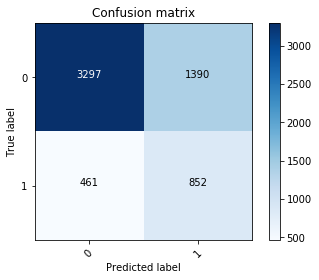

Accuracy: 0.6915, F1: 0.4793248945147679, AUC: 0.67617 

Feature coefficients: 

        Feature   Coefficient
2         PAY_0  5.068086e-01
22  EDUCATION_1  2.230075e-01
23  EDUCATION_2  1.723388e-01
24  EDUCATION_3  1.427907e-01
3         PAY_2  9.808943e-02
26   MARRIAGE_1  7.541045e-02
4         PAY_3  5.760926e-02
5         PAY_4  4.144777e-02
6         PAY_5  9.141468e-03
1           AGE  7.408429e-03
10    BILL_AMT3  1.665594e-06
9     BILL_AMT2  1.612224e-06
12    BILL_AMT5  7.284203e-07
13    BILL_AMT6 -1.324716e-07
0     LIMIT_BAL -7.649869e-07
11    BILL_AMT4 -7.921691e-07
18     PAY_AMT5 -9.315974e-07
16     PAY_AMT3 -1.026561e-06
19     PAY_AMT6 -2.261266e-06
17     PAY_AMT4 -3.146904e-06
8     BILL_AMT1 -4.541967e-06
15     PAY_AMT2 -9.321287e-06
14     PAY_AMT1 -9.869126e-06
20        SEX_1 -5.119606e-03
7         PAY_6 -6.972023e-03
27   MARRIAGE_2 -8.977313e-02
28   MARRIAGE_3 -1.182116e-01
21        SEX_2 -1.274546e-01
25  EDUCATION_4 -6.707113e-01


In [45]:
## Final model selected:

lr_model = LogisticRegression(random_state=42,                           
                           solver='newton-cg',
                           C=7,
                           class_weight='balanced',
                           max_iter=150,
                           n_jobs=1,
                           penalty='l2'
                           )

#lr_model = LogisticRegression(random_state=42,                           
#                           solver='newton-cg',
#                           C=4.32,
#                           class_weight='balanced',
#                           max_iter=150,
#                           n_jobs=-1,
#                           penalty='l2'
#                           )

lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(conf_matrix, classes = [0,1])

# y_test.hist()
# pd.DataFrame(data=y_pred).hist()

acc_score = accuracy_score(y_test, y_pred)
f_one_score = f1_score(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

auc_score = str(round(auc(fpr, tpr),5))


print('Accuracy: {}, F1: {}, AUC: {} \n'.format(acc_score,f_one_score, auc_score))

coefficients = pd.concat([pd.DataFrame(X_test.columns),pd.DataFrame(np.transpose(lr_model.coef_))], axis = 1)
coefficients.columns = ['Feature','Coefficient']

print('Feature coefficients: \n')
print(coefficients.sort_values(by='Coefficient', ascending=False))


## Multiple Logistic Regression - results

It seems that the most relevant coefficients are the ones connected to variable PAY, especially the PAY_0 and EDUCATION features which is most important. This would mean that the most recent repayment status has the most influence on the default in current month.

AUC seems quite poor when compared to solving some other problems, but still might be usable to establish some results as a Proog Of Concept and baseline of what is possible with the data given.

For logistic regression i will also attempt a very simple model with just a single variable in order to check its performance also.
    

Confusion matrix, without normalization
[[3992  695]
 [ 630  683]]


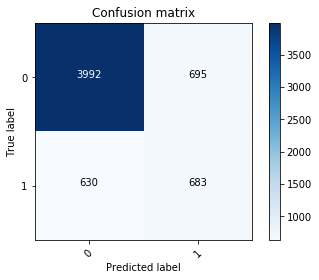

Accuracy: 0.7791666666666667, F1: 0.5076179858788553, AUC: 0.68595 



In [46]:
#########################################
## 2 ## Univariate logistic regression  #
#########################################

lr_model.fit(np.array(X_train['PAY_0']).reshape(-1,1), y_train)

#np.array(X_train['PAY_0']).reshape(-1,1)
#np.array(X_train['PAY_0']).reshape(1,-1)

y_pred = lr_model.predict(np.array(X_test['PAY_0']).reshape(-1,1))

conf_matrix = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(conf_matrix, classes = [0,1])

# y_test.hist()
# pd.DataFrame(data=y_pred).hist()

acc_score = accuracy_score(y_test, y_pred)
f_one_score = f1_score(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

auc_score = str(round(auc(fpr, tpr),5))

print('Accuracy: {}, F1: {}, AUC: {} \n'.format(acc_score,f_one_score, auc_score))


Confusion matrix, without normalization
[[4000  687]
 [ 630  683]]


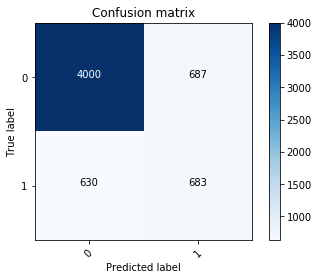

Accuracy: 0.7805, F1: 0.5091315691390235, AUC: 0.70103 



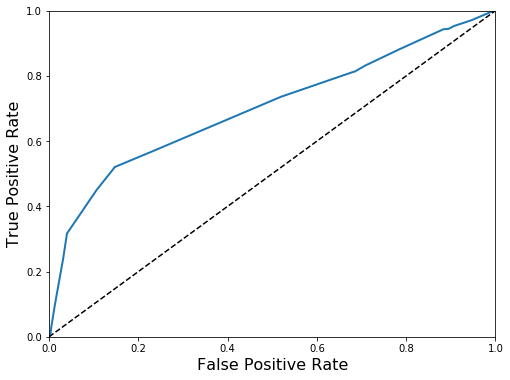

In [47]:
######################################################################
## 3 ## Multivariate logistic regression - 4 most important features #
######################################################################

lr_model.fit(X_train[['PAY_0','EDUCATION_1','EDUCATION_2','EDUCATION_3']], y_train)

#np.array(X_train['PAY_0']).reshape(-1,1)
#np.array(X_train['PAY_0']).reshape(1,-1)

y_pred = lr_model.predict(X_test[['PAY_0','EDUCATION_1','EDUCATION_2','EDUCATION_3']])
y_pred_proba = lr_model.predict_proba(X_test[['PAY_0','EDUCATION_1','EDUCATION_2','EDUCATION_3']])[:,1]

conf_matrix = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(conf_matrix, classes = [0,1])

# y_test.hist()
# pd.DataFrame(data=y_pred).hist()

acc_score = accuracy_score(y_test, y_pred)
f_one_score = f1_score(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)

auc_score = str(round(auc(fpr, tpr),5))

print('Accuracy: {}, F1: {}, AUC: {} \n'.format(acc_score,f_one_score, auc_score))

plot_roc_curve(fpr, tpr)

## Multiple Logistic Regression with 4 vaiables - results

The very simple model has performed slightly better than the full model, but by choosing the top 4 variables from the initial Multiple Logistic Regression model we have achieved the best performance on both accuracy and AUC.

There are some other more elaborate methods how to choose the best number of variables in regression, but at this point we have a good baseline against which we can test some other models as well.


Tree enembles - Gradient Boosting Classifier
--------------------



In [48]:
model = GradientBoostingClassifier(random_state=42)

params = {'n_estimators':sp_randint(50, 200),
          'min_samples_leaf':sp_randint(20, 100),
          'max_depth':sp_randint(2, 3),
          'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]}

random_search = RandomizedSearchCV(model, 
                                   param_distributions=params, 
                                   cv=3, 
                                   n_iter=21,
                                   scoring='roc_auc',
                                   iid=False, 
                                   verbose=100)


### Randomized Search CV with validation on the test set 
# scores = cross_val_score(random_search, X_train, y_train, 
#                         scoring='accuracy', cv=5)
# print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),
#                                      np.std(scores)))



random_search.fit(X_train, y_train)

print(random_search.best_estimator_)
print(random_search.best_score_)


Fitting 3 folds for each of 21 candidates, totalling 63 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] learning_rate=0.6, max_depth=2, min_samples_leaf=79, n_estimators=74 
[CV]  learning_rate=0.6, max_depth=2, min_samples_leaf=79, n_estimators=74, score=0.779, total=   0.9s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[CV] learning_rate=0.6, max_depth=2, min_samples_leaf=79, n_estimators=74 
[CV]  learning_rate=0.6, max_depth=2, min_samples_leaf=79, n_estimators=74, score=0.779, total=   1.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[CV] learning_rate=0.6, max_depth=2, min_samples_leaf=79, n_estimators=74 
[CV]  learning_rate=0.6, max_depth=2, min_samples_leaf=79, n_estimators=74, score=0.767, total=   1.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s
[CV] learning_rate=0.1, max_depth=2, min_samples_leaf=59, n_estimators=84 
[CV]  lea

[CV]  learning_rate=0.8, max_depth=2, min_samples_leaf=93, n_estimators=180, score=0.765, total=   2.2s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:   49.1s remaining:    0.0s
[CV] learning_rate=0.8, max_depth=2, min_samples_leaf=93, n_estimators=180 
[CV]  learning_rate=0.8, max_depth=2, min_samples_leaf=93, n_estimators=180, score=0.755, total=   2.5s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:   51.6s remaining:    0.0s
[CV] learning_rate=0.05, max_depth=2, min_samples_leaf=56, n_estimators=166 
[CV]  learning_rate=0.05, max_depth=2, min_samples_leaf=56, n_estimators=166, score=0.781, total=   2.3s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:   54.0s remaining:    0.0s
[CV] learning_rate=0.05, max_depth=2, min_samples_leaf=56, n_estimators=166 
[CV]  learning_rate=0.05, max_depth=2, min_samples_leaf=56, n_estimators=166, score=0.785, total=   2.2s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   56.2s remaining:    0.0s
[CV] learning_rate=0.05, max_dep

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=47, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=186,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
0.7796849691311527


Confusion matrix, without normalization
[[4449  238]
 [ 844  469]]


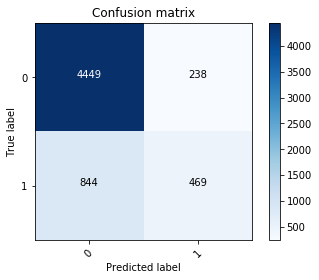

Accuracy: 0.8196666666666667, F1: 0.4643564356435644, AUC: 0.7821 



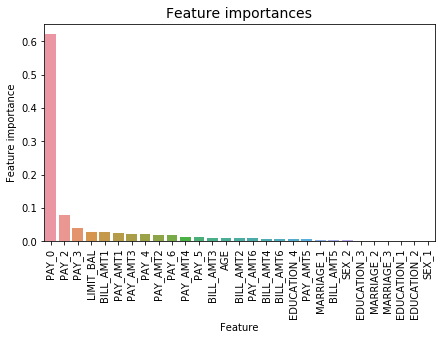

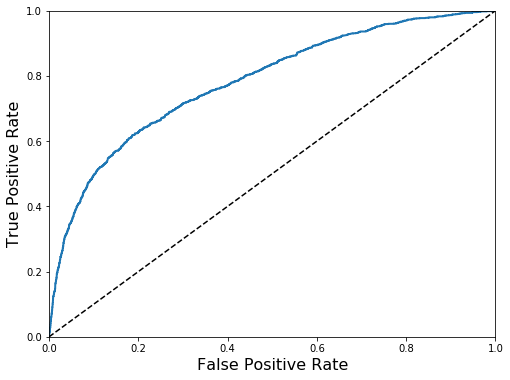

In [49]:
## Final model selected:

gbc_model = random_search.best_estimator_

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

conf_matrix = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(conf_matrix, classes = [0,1])

# y_test.hist()
# pd.DataFrame(data=y_pred).hist()

acc_score = accuracy_score(y_test, y_pred)
f_one_score = f1_score(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)

auc_score = str(round(auc(fpr, tpr),5))

print('Accuracy: {}, F1: {}, AUC: {} \n'.format(acc_score, f_one_score, auc_score))

show_feature_importances(X_train.columns, model)

# plotLearningCurve(X_train, y_train, random_search.best_estimator_)

plot_roc_curve(fpr, tpr)

## Tree Ensembles - GBC results

Now we have achieved an AUC score of 0.7812 which is better than with the Logistic Regression. The main feature is again PAY_0 while other PAY variables have some infulence as well. In this model the EDUCATION is not that important. 


Tree Ensembles - XGBoost 
-----

I wanted to try out also the XGBoost as it is one of the more used algorithms in professional competitions. Many iterations have been done with XGB in order to find the below parameters by using the sklearn wrapper. Below is the final model which gave the best AUC.


In [52]:
################
## XGBoost #####
################

def XGB_plot_importance(model):

    fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
    xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="blue") 
    plt.show()
    
    
def runXGBoost(X_train, X_test, y_train, y_test, imbalanced_proportion): 

    d_train = xgb.DMatrix(X_train, y_train)
    d_test = xgb.DMatrix(X_test, y_test)
    
    watchlist = [(d_train, 'train'), (d_test, 'test')]
    
    params = {'objective': 'binary:logistic'
              , 'learning_rate': 0.2
              , 'n_estimators': 106
              , 'min_samples_leaf': 106
              , 'random_state': 42
              , 'scale_pos_weight': imbalanced_proportion
              , 'eval_metric': 'auc'          
            }
    
    max_rounds = 1000
    early_stop_rounds = 30
    
    xgbc_model = xgb.train(params
                      , d_train
                      , max_rounds
                      , watchlist
                      , early_stopping_rounds=early_stop_rounds
                      )
    
    XGB_plot_importance(xgbc_model)
      
    y_pred_proba = xgbc_model.predict(d_test, ntree_limit=xgbc_model.best_ntree_limit)
    y_pred = [int(x >= 0.22) for x in y_pred_proba]
        
    conf_matrix = confusion_matrix(y_test, y_pred)

    plot_confusion_matrix(conf_matrix, classes = [0,1])        
    
    acc_score = accuracy_score(y_test, y_pred)
    f_one_score = f1_score(y_test, y_pred)
        
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
    auc_score = str(round(auc(fpr, tpr),5))
    print('Accuracy: {}, F1: {}, AUC: {} \n'.format(acc_score, f_one_score, auc_score))
    
    plot_roc_curve(fpr, tpr)
    
    
imbalanced_proportion = sum(y) / y[y==0].count()

[0]	train-auc:0.762635	test-auc:0.752725
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 30 rounds.
[1]	train-auc:0.768714	test-auc:0.757574
[2]	train-auc:0.774892	test-auc:0.762492
[3]	train-auc:0.779451	test-auc:0.767599
[4]	train-auc:0.780829	test-auc:0.766525
[5]	train-auc:0.784023	test-auc:0.767452
[6]	train-auc:0.787767	test-auc:0.770096
[7]	train-auc:0.792308	test-auc:0.775656
[8]	train-auc:0.794907	test-auc:0.776538
[9]	train-auc:0.797053	test-auc:0.777234
[10]	train-auc:0.800191	test-auc:0.778337
[11]	train-auc:0.803652	test-auc:0.778522
[12]	train-auc:0.806677	test-auc:0.778861
[13]	train-auc:0.808788	test-auc:0.778298
[14]	train-auc:0.811262	test-auc:0.778127
[15]	train-auc:0.813188	test-auc:0.778956
[16]	train-auc:0.813549	test-auc:0.778577
[17]	train-auc:0.815873	test-auc:0.779211
[18]	train-auc:0.818414	test-auc:0.780339
[19]	train-auc:0.819155	test-auc:0.779562
[20]	train-auc:0.820519	test-

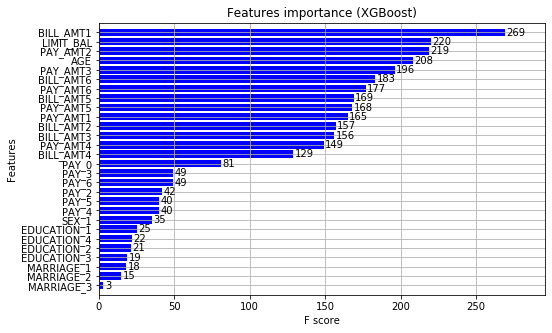

Confusion matrix, without normalization
[[4415  272]
 [ 802  511]]


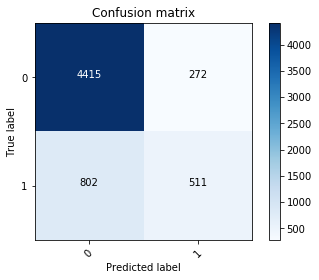

Accuracy: 0.821, F1: 0.4875954198473281, AUC: 0.78325 



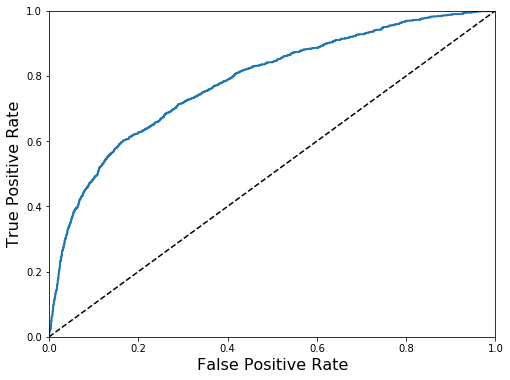

In [53]:
runXGBoost(X_train, X_test, y_train, y_test, imbalanced_proportion)

## Tree Ensembles - XGBoost results

Although we have imporved the AUC score just slightly the distributions in the confusion matrix are not favorable, as we can only predict 177 clients that defaulted correctly. It is interesting to see that XGB has used some another variable called BILL_AMT1 as a most important while EDUCATION variables are once more not so relevant.

Support Vector Machine
-----

One last approach is using the SVM with the same data. It does function in a different way as all the previous algorithms so maybe there will be another insight about the model and predictions.

In [26]:
##########################
# Support Vector Machine #
##########################

model = SVC(kernel='rbf', class_weight='balanced')

steps = [('scaler', StandardScaler()), ('SVC', model)]
pipeline = Pipeline(steps) 

# after a couple of rounds of Grid Search...

params = {'SVC__C':[10, 12],
          'SVC__gamma':[0.015, 0.02]}

grid_search = GridSearchCV(pipeline, 
                           param_grid=params, 
                           cv=3, 
                           scoring='accuracy',
                           verbose=100)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] SVC__C=10, SVC__gamma=0.015 .....................................
[CV] ......... SVC__C=10, SVC__gamma=0.015, score=0.772, total=  15.2s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.2s remaining:    0.0s
[CV] SVC__C=10, SVC__gamma=0.015 .....................................
[CV] ......... SVC__C=10, SVC__gamma=0.015, score=0.781, total=  15.3s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   30.5s remaining:    0.0s
[CV] SVC__C=10, SVC__gamma=0.015 .....................................
[CV] ......... SVC__C=10, SVC__gamma=0.015, score=0.764, total=  15.6s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   46.1s remaining:    0.0s
[CV] SVC__C=10, SVC__gamma=0.02 ......................................
[CV] .......... SVC__C=10, SVC__gamma=0.02, score=0.772, total=  15.8s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed

In [29]:
# model with the predicted probabilities so we can build the AUC curve

svc_model = grid_search.best_estimator_

svc_model.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('SVC',
                 SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=0.015,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

Confusion matrix, without normalization
[[3855  832]
 [ 548  765]]


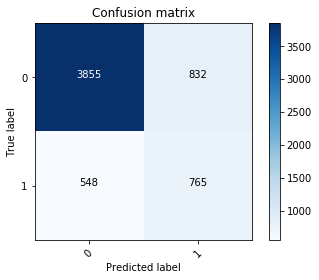

Accuracy: 0.77, F1: 0.5257731958762887


In [44]:
# Make predictions and deliver results

# y_pred_proba = svc_model.predict_proba(X_test)
y_pred = svc_model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(conf_matrix, classes = [0,1])

acc_score = accuracy_score(y_test, y_pred)
f_one_score = f1_score(y_test, y_pred)

# fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1], pos_label=1)
# auc_score = str(round(auc(fpr, tpr),5))

print('Accuracy: {}, F1: {}'.format(acc_score, f_one_score))

# plot_roc_curve(fpr, tpr)

## Support Vector Machine - results

Probabilities for the SVC are a bit more complex to calculate, hence only the accuracy and F1 score is used used here in combination with the confusion matrix. F1 score is in this case not better than the tree methods. 

# Modelling results

With AUC of 0.7834 the XGB is the most robust model out of the 4 that we have tried. Hence, this model could be productionized. Just the AUC score does not tell us the complete story, because how to use the model is dependant on the kind of questions that would get priority. 

For instance it might be much more interesting to be able to predict the clients that will default in the next period then the ones that will not. Certain measures could then be employed to prevent the default of the client. E.g. a simple telephone call as a reminder could have a positive effect. Effect of each of these initiatives could be also measured through hypothesis testing to see if the effect is real or not. If yes, then the features about the phone calls could be also included to improve the performance of the model. 

## Important data details

The information about the data is not detailed enough for someone who is not the domain expert to completely understand what the data represents. Because of that some of the details might be misunderstood and the feature engineering would be less effective.

There are only 30K entries present, but it is very possible that much more cases are available. Also there might be more details about the clients that would be helpfull in predicting default. I would like to have access to more data and also a chance to talk with domain expert on a more detail level in order to create more useful model.

## Anserwing the initial questions

### Q1. Can we predict which clients will default in the next period?

Well, yes, at least some of them. We would have to decide on the treshold based on the AUC curve in order to select the clients that are very likely to default. With them we will inevidably select a certain amount of clients that will not default (false positives) as the model is not perfect. In the context of the initiative that we might be attempting (a phone call) that might be perfectly fine, but should be treated as a wastefull cost and carefully tracked so that it does not get out of hand.


### Q2. If so, how accurate can we get?

By looking at the AUC of the best model (XGB) we could choose a treshold of TPR = 0.5 and FPR 0.05. Hence, we can correctly predict about 50% of the clients that would default and to do that we will also select about 5% of the clients that we missclassified that they will default when in fact they will not. In practical terms i would call this a useful case and take a look at the costs of implementing an initiative.


### Q3. Can we also predict what is the clients probability of defaulting in the next period?

Yes, XGB is implemented in such a way that it has avaialble also to probability of each client that it will default. This is very usefull as it can give the relative probabilities and not only 0 and 1 so we can understand better out of the clients that we predicted that will default, which ones we are very likely to default.


### Q4. Are there any ideas on how to improve the accuracy?

Although we used different metrics to compare the model performance, the model performance could be improved by investing more time into feature engineering, talking to domain knowledge owners and retrieving new features, and trying out some of the other approaches. 

